<a href="https://colab.research.google.com/github/nedokormysh/GB_NLP_intro/blob/lesson4/NLP_intro_hw_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Тематическое моделирование
Скачиваем датасет (источник): положительные, отрицательные.

или можно через ноутбук

!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv !wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

как альтернатива можно скачать данные из Роспотребнадзора https://zpp.rospotrebnadzor.ru/Forum/Appeals для этого берём ноутбук parse_rospotrebnadzor.ipynb устанавливаем количество скачанных страниц больше не 50-сят хотябы 500 и для анализа берём только вопросы так как ответы есть не всегда

объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов

# Качаем данные.

In [ ]:
import requests
from bs4 import BeautifulSoup 
import time
from urllib.parse import urlparse, urljoin
from tqdm.notebook import tqdm

In [ ]:
## найти id каждого вопроса на страницах
page = 1
main_url = 'https://zpp.rospotrebnadzor.ru/Forum/Appeals/AjaxindexList?page={page}&searchtext=&categories=[]'

def ids_from_page(soup):
    return [i.get('href') for i  in soup.findAll('a', {'class':'appeal-title-link'})]
    
urls = []
for page in tqdm(range(1, 50), desc='Pages'):
    time.sleep(0.5)
    res = requests.get(main_url.format(page=page))  
    soup = BeautifulSoup(res.text)
    urls.extend(ids_from_page(soup))

Pages:   0%|          | 0/49 [00:00<?, ?it/s]

In [ ]:
## имея id запросов достанем тексты на страницах
domain = 'https://zpp.rospotrebnadzor.ru'

def get_text_page_question(soup):
    return soup.findAll('p', {'class':'appeal-details-message'})[0].text
def get_text_page_answer(soup):
    return soup.findAll('p', {'class':'appeal-comments-message'})[0].text

question = []
answers = []

for url in tqdm(urls, desc='Pages'):
    time.sleep(0.5)
    res = requests.get(urljoin(domain, url))  
    soup = BeautifulSoup(res.text)
    
    question.append(get_text_page_question(soup))
    try:
        answers.append(get_text_page_answer(soup))
    except:
        answers.append('No answer')

Pages:   0%|          | 0/245 [00:00<?, ?it/s]

In [ ]:
!pip install pymorphy2 -q

In [ ]:
!pip install stop_words -q

In [ ]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from stop_words import get_stop_words
import nltk
from nltk.tokenize import word_tokenize
import re
from pymorphy2 import MorphAnalyzer

In [ ]:
df = pd.DataFrame(question, columns=['question'])

In [ ]:
df.to_csv('rospotrebnadzor.csv', index=False)
df = pd.read_csv('rospotrebnadzor.csv')
df

,question
0,Здравствуйте! 18.02.2023 оформила заказ и сраз...
1,Добрый день.город Киров.\r\nТакая история:окол...
2,Здравствуйте!\r\nМне сегодня без уважительной ...
3,Предзаказал игру Atomic Heart. Покупал через о...
4,20.02.2023 года мной был оформлен и оплачен за...
...,...
240,"Здравствуйте,ребенок 3лет,по ошибке подключил ..."
241,Здравствуйте. Хочу пожаловаться на маркетплейс...
242,"Здравствуйте. В магазине торговой сети ""Пятеро..."
243,Жалоба на отказ ООО Вайлдберриз в добровольном...


# Препроцессинг

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\недокормыш\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [ ]:
# nltk.download('stopwords')
words_regex = re.compile('\w+')
morpher = MorphAnalyzer()
my_stopwords = ['здравствуйте', 'добрый', 'день', 'вопрос', 'роспотребнадзор', 'либо', 'месяц', 
                'течение', 'данный', 'это', 'просить', 'сказать', 'год', 'адрес', 'обращение', 'мочь', 'иметь', 'человек',
                'право']

stopwords = set(get_stop_words("ru") + my_stopwords)

def preprocess_txt(line):
    line = line.lower() # Нижний регистр
    line = re.sub(r'[^\w\s]', ' ', line) # Пунктуация
    line = re.sub(" \d+", " ", line) # Числа
    words = word_tokenize(line) # Токенизация
    words = [morpher.parse(word)[0].normal_form for word in words] # Лемматизация
    words = [word for word in words if len(word)>3] # Слова длинной меньше 3 символов
    words = [word for word in words if word not in stopwords] # Стоп слова
   
    return words

In [ ]:
# nltk.download('stopwords')
# words_regex = re.compile('\w+')
# morph = MorphAnalyzer()
# my_stopwords = ['здравствуйте', 'добрый', 'день', 'вопрос', 'роспотребнадзор', 'либо', 'месяц', 
#                 'течение', 'данный', 'это', 'просить', 'сказать', 'год', 'адрес', 'обращение', 'мочь', 'иметь', 'человек',
#                 'право', 'санкт' ,'петербург']

# def find_words(text, regex = words_regex):
#     tokens =  regex.findall(text.lower())
#     return [w for w in tokens if w.isalpha() and len(w) >= 3]


# stopwords_list = stopwords.words('russian') + my_stopwords

# # mystem = Mystem()
# # def lemmatize(words, lemmer = mystem, stopwords = stopwords_list):
# #     lemmas = lemmer.lemmatize(' '.join(words))
# #     return [w for w in lemmas if not w in stopwords 
# #             and w.isalpha()]

# def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
#     lemmas = [lemmer.parse(w)[0].normal_form for w in words]
#     return [w for w in lemmas if not w in stopwords 
#             and w.isalpha()]

# def preprocess(text):
#     return (lemmatize(find_words(text)))

In [ ]:
df.question.iloc[1]

'Добрый день.город Киров.\r\nТакая история:около месяца назад я купила в магазине домашние брюки и они оказались плохого качества(после стирки портят мебель и руки-линяют).Этот их недостаток я заметила после истечения 2 недель от даты покупки.Я написала в основную группу магазина в интернете,скорее всего в московскую.Объяснила им,что с момента покупки прошло больше 2 недель,они сказали,что и сейчас можно прийти в магазин с некачественным товаром,написать претензию,деньги вернуть должны.А пришла в магазин,мне сказали извините,срок возврата 2 недели...На мои слова о том,что я писала в основную группу и там мне сказали прийти в магазин с вещью,пожимают плечами...Очень обидно😔 Скажите,кто здесь прав?'

In [ ]:
print(preprocess_txt(df.question.iloc[1]))

['город', 'киров', 'история', 'купить', 'магазин', 'домашний', 'брюки', 'оказаться', 'плохой', 'качество', 'стирка', 'портить', 'мебель', 'рука', 'линять', 'недостаток', 'заметить', 'истечение', 'неделя', 'дата', 'покупка', 'написать', 'основный', 'группа', 'магазин', 'интернет', 'скорее', 'московский', 'объяснить', 'момент', 'покупка', 'пройти', 'большой', 'неделя', 'прийти', 'магазин', 'некачественный', 'товар', 'написать', 'претензия', 'деньга', 'вернуть', 'должный', 'прийти', 'магазин', 'извинить', 'срок', 'возврат', 'неделя', 'слово', 'писать', 'основный', 'группа', 'прийти', 'магазин', 'вещь', 'пожимать', 'плечо', 'обидно']


In [ ]:
preprocessed_text = list(tqdm(map(preprocess_txt, df['question']), total=len(df)))

  0%|          | 0/245 [00:00<?, ?it/s]

In [ ]:
df['prep_text'] = preprocessed_text
df.sample(3)

,question,prep_text
146,Здравствуйте! Подскажите пожалуйста какими зак...,"[подсказать, закон, подзаконный, регулироватьс..."
39,Здравствуйте. Хотели провести детский день рож...,"[провести, детский, рождение, детский, комната..."
74,Сделал заказ на сайте Wildberries. Покупка осу...,"[сделать, заказ, сайт, wildberries, покупка, о..."


# LDA

In [ ]:
# !pip install -U gensim -q

In [ ]:
# Импорт библиотек

from gensim.models import *
from gensim import corpora
from gensim.models.phrases import Phraser

In [ ]:
dictionary = corpora.Dictionary(df['prep_text'])

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('rospotrebnadzor.dict')

In [ ]:
# Векторизация документов

corpus = [dictionary.doc2bow(text) for text in df['prep_text']]
corpora.MmCorpus.serialize('rospotrebnadzor.model', corpus) 

In [ ]:
# Обучение модели

%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

Wall time: 664 ms


In [ ]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(2,
  '0.060*"почта" + 0.058*"документ" + 0.057*"https" + 0.053*"товар" + 0.049*"номер" + 0.049*"передать" + 0.047*"ответ" + 0.042*"оплатить" + 0.033*"заказ" + 0.031*"обнаружить"'),
 (19,
  '0.214*"товар" + 0.067*"заказ" + 0.059*"деньга" + 0.057*"доставка" + 0.055*"возврат" + 0.033*"поддержка" + 0.030*"списать" + 0.027*"заказать" + 0.026*"сервис" + 0.025*"брак"'),
 (6,
  '0.428*"связь" + 0.207*"оператор" + 0.154*"счёт" + 0.111*"являться" + 0.001*"предоставить" + 0.001*"момент" + 0.001*"пройти" + 0.001*"декабрь" + 0.001*"лицо" + 0.001*"требование"'),
 (7,
  '0.106*"деньга" + 0.057*"телефон" + 0.054*"делать" + 0.050*"размер" + 0.048*"согласно" + 0.047*"купить" + 0.046*"вернуть" + 0.040*"писать" + 0.034*"февраль" + 0.033*"ситуация"'),
 (0,
  '0.403*"магазин" + 0.067*"покупка" + 0.051*"далее" + 0.048*"прийти" + 0.044*"упаковка" + 0.039*"результат" + 0.039*"проверить" + 0.031*"продукт" + 0.027*"проверка" + 0.027*"написать"'),
 (13,
  '0.294*"дата" + 0.228*"сайт" + 0.194*"указать" + 0.044*"

визуализация

In [ ]:
# conda install pyLDAvis -q

In [ ]:
# Импорт библиотек

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

D:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


Wall time: 16.1 s


In [ ]:
# Перплексия и когерентность

coherence_model_lda = CoherenceModel(model=lda, texts=df['prep_text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))
print('Средняя когерентность: ', coherence_lda)

Персплексия:  0.0028348193133186594
Средняя когерентность:  0.29505851512876136


  0%|          | 0/23 [00:00<?, ?it/s]

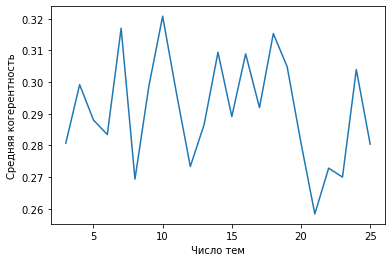

In [ ]:
# Подбор количества тем

topics_list = list(range(3, 26))
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=df['prep_text'], dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

In [ ]:
# Обучаем модель с новым количеством тем

lda_5 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=7, chunksize=50, update_every=1, passes=2)
vis_data = gensimvis.prepare(lda_5, corpus, dictionary)
pyLDAvis.display(vis_data)

D:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [ ]:
vis_data.topic_info.Category

125    Default
32     Default
15     Default
25     Default
169    Default
        ...   
10      Topic7
11      Topic7
5       Topic7
23      Topic7
17      Topic7
Name: Category, Length: 294, dtype: object

In [ ]:
topic_names_list = vis_data.topic_info.Category.unique()

In [ ]:
for topic_name in topic_names_list[1:]:
  print(list(vis_data.topic_info.loc[vis_data.topic_info.Category == topic_name].Term[:8]))

['договор', 'компания', 'случай', 'площадка', 'москва', 'получение', 'отказываться', 'ошибка']
['область', 'приложение', 'потребитель', 'услуга', 'банк', 'никто', 'взять', 'защита']
['факт', 'сервис', 'пройти', 'покупка', 'доставить', 'интернет', 'купить', 'смочь']
['цель', 'полный', 'лицо', 'установить', 'установленный', 'находиться', 'требование', 'район']
['согласно', 'направить', 'ждать', 'январь', 'оператор', 'слово', 'отсутствие', 'предоставить']
['онлайн', 'мера', 'делать', 'предложить', 'возможность', 'карта', 'принять', 'часть']
['заранее', 'продажа', 'цена', 'просьба', 'указать', 'жалоба', 'продавец', 'ответственность']


1) Оказание услуг по договору

2) Защита потребителя

3) Интернет доставка

4) Не смог интерпретировать

5) Не смог интерпретировать

6) Проблема с онлайн работой карты

7) Проблема в покупке.

В целом всё достаточно сложно интрепретировать однозначно эти вопросы. Возможно следует улучшить фильтрацию.

Также стандартные версии библиотек на колабе выдавали где-то ошибки. Делал всё локально. Так что возможно чистый запуск в колабе не сработает.